In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-covid-sa-fake-sentiment/data-covid-sa-fake-sentiment.xlsx
/kaggle/input/data-covid-sa-fake-sentiment/Stopwords.txt


In [2]:
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install transformers openpyxl tqdm datasets scikit-learn gradio torch accelerate -q

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-2gu6nq1f
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-2gu6nq1f
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=46d874c830f277970a279afd9540021ba2e9fcec2aad824b36c91ad5c1b10577
  Stored in directory: /tmp/pip-ephem-wheel-cache-rg4ql3b5/wheels/9a/af/fc/4c056274507dc80328a36c6ee1b71d78d6473edb0c1f5edc3e
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=a056ae897ace5b7d14d9e7f7901220e

In [3]:
import math, json, re, random, time, gc
from dataclasses import dataclass
from typing import List, Dict, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import transformers
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup, AutoConfig, PreTrainedModel, PretrainedConfig

from normalizer import normalize
from multiprocessing import Pool, cpu_count
import shutil
import warnings
warnings.filterwarnings('ignore')

2025-09-06 14:56:21.283676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757170581.471114      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757170581.522996      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
torch.backends.cudnn.benchmark = True  # Faster convolutions for fixed input sizes
torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 for matmul (faster)
torch.backends.cudnn.allow_tf32 = True  # Allow TF32 for convolutions

In [5]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
# ----- Paths -----
EXCEL_PATH = "/kaggle/input/data-covid-sa-fake-sentiment/data-covid-sa-fake-sentiment.xlsx"  # change if needed
SAVE_DIR   = "/kaggle/working/banglabert_multitask"
os.makedirs(SAVE_DIR, exist_ok=True)

In [7]:
# ----- Hyperparameters -----
MODEL_NAME = "csebuetnlp/banglabert_small"
MAX_LENGTH = 512
BATCH_SIZE = 32
GRAD_ACCUM_STEPS = 2
EPOCHS = 12
FIXED_LR = 3e-5
FIXED_SMOOTHING = 0.1
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01
ALPHA_SENTIMENT = 0.75
DEBUG_MODE = False  # Set to True for quick testing

# Optional gradient checkpointing (set to True only if OOM)
USE_GRAD_CHECKPOINT = False

In [8]:
SENTIMENT_MAP = {"negative":0, "neutral":1, "positive":2}
TRUTH_MAP     = {"fake":0, "real":1}

In [9]:
# Reverse maps for decoding
idx2sent = {v: k for k, v in SENTIMENT_MAP.items()}
idx2truth = {v: k for k, v in TRUTH_MAP.items()}

In [10]:
df = pd.read_excel(EXCEL_PATH)

In [11]:
# keep first occurrence of exact duplicates (text + both labels identical)
df = df.drop_duplicates(subset=["text", "sentiment", "truthfulness"], keep="first")

In [12]:
# --- 1. Basic Overview ---
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nSample rows:\n", df.head())

Dataset shape: (35526, 3)

Column names: ['text', 'sentiment', 'truthfulness']

Data types:
 text            object
sentiment       object
truthfulness    object
dtype: object

Missing values:
 text            0
sentiment       0
truthfulness    0
dtype: int64

Sample rows:
                                                 text sentiment truthfulness
0  করোনা বিষয়ে চারটি পৃথক কমিটি করেছে স্বাস্থ্য অ...   Neutral         real
1  চট্টগ্রামে করোনাভাইরাসে আক্রান্ত আরও একজনের মৃ...  Negative         real
2  যশোরে করোনাভাইরাসে আক্রান্ত হয়ে এক দিনে দুজনের...  Negative         real
3  রাজশাহীতে আজ রোববার ৩১ জনের নমুনা পরীক্ষায় ৯ জ...  Negative         real
4  চট্টগ্রামে নতুন করে ৯ জনের করোনা শনাক্ত হয়েছে।...  Negative         real


In [13]:
df['sentiment'].value_counts()

sentiment
Negative    15453
Positive    14939
Neutral      5134
Name: count, dtype: int64

In [14]:
df['truthfulness'].value_counts()

truthfulness
real    25940
fake     9586
Name: count, dtype: int64

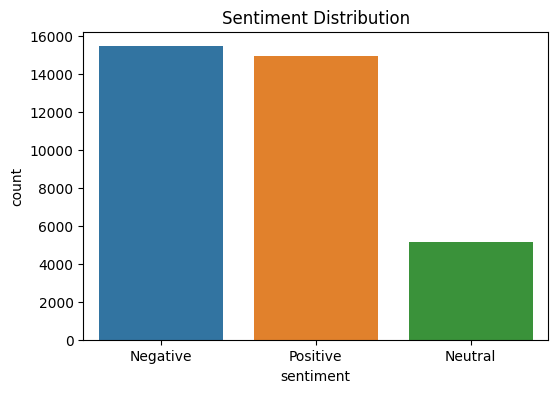

In [15]:
# --- 2. Sentiment Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title("Sentiment Distribution")
plt.show()

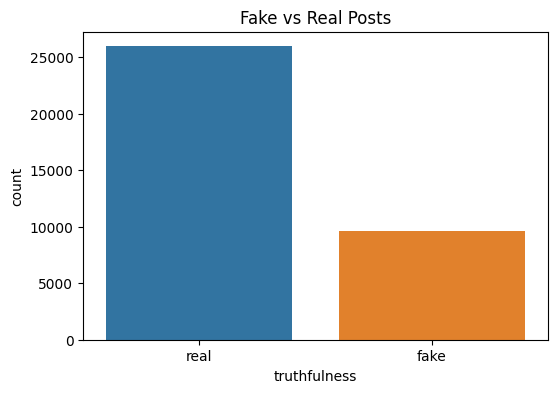

In [16]:
# --- 3. Fake vs Real Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='truthfulness', data=df)
plt.title("Fake vs Real Posts")
plt.show()

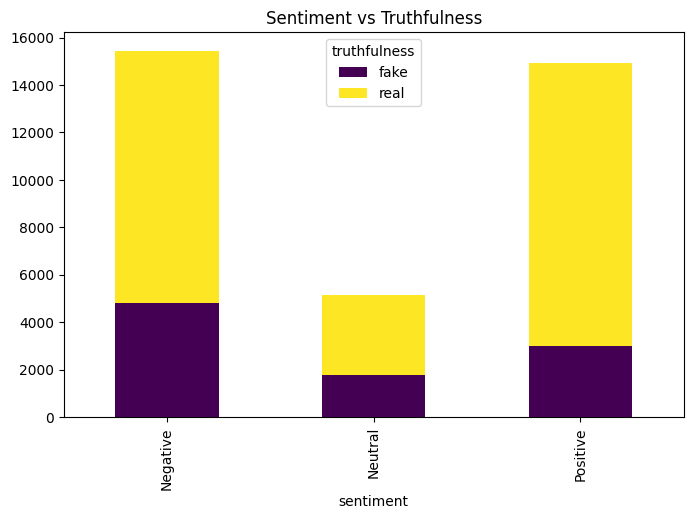

In [17]:
# Crosstab of Fake/Real vs Sentiment
cross_tab = pd.crosstab(df['sentiment'], df['truthfulness'])
cross_tab.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')
plt.title("Sentiment vs Truthfulness")
plt.show()

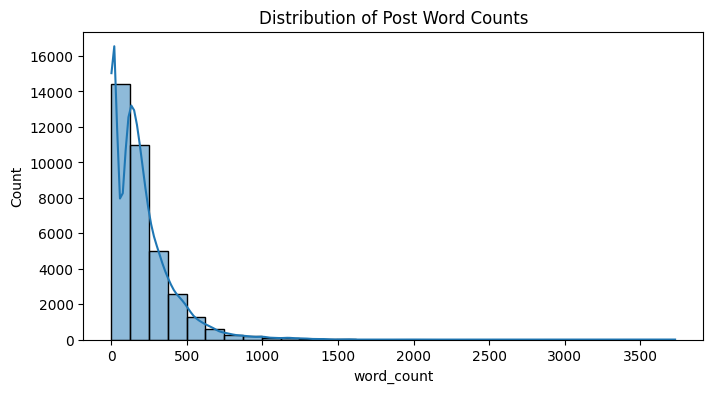

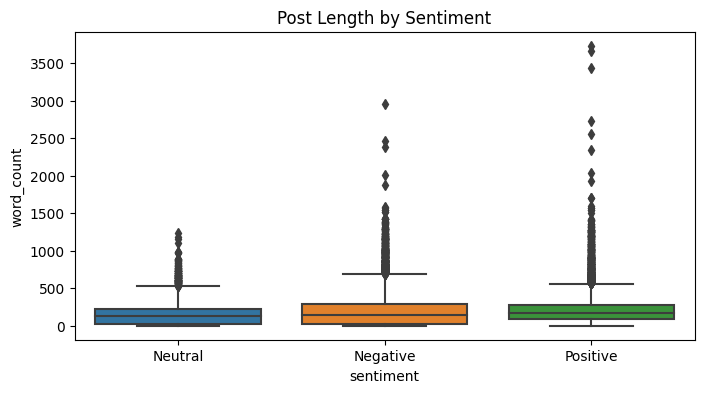

In [18]:
# --- 4. Text Length Analysis ---
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title("Distribution of Post Word Counts")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title("Post Length by Sentiment")
plt.show()

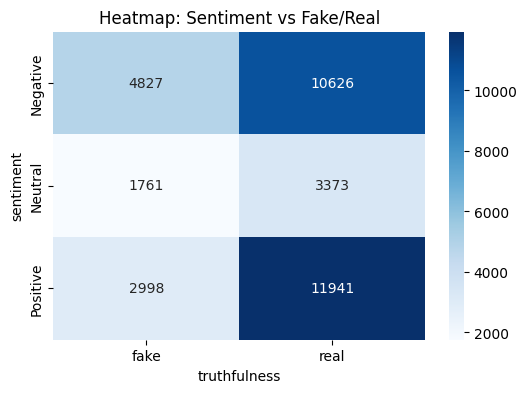

In [19]:
# --- 7. Heatmap: Sentiment vs Fake/Real ---
plt.figure(figsize=(6,4))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap: Sentiment vs Fake/Real")
plt.show()

In [20]:
# 1️⃣ Compile the “whitespace‑collapse” regex once (global)
_COLLAPSE_RE = re.compile(r"\s+")

def _clean_one(text: str) -> str:
    """
    Normalise a **single** string, then collapse whitespace and strip.
    This function is deliberately tiny – it will be executed in a separate
    process, so we want to avoid any heavy imports inside it.
    """
    txt = normalize(
        text,
        unicode_norm="NFKC",
        punct_replacement=None,
        url_replacement="",
        emoji_replacement="",
        apply_unicode_norm_last=True,
    )
    # Collapse any run of whitespace into a single space
    txt = _COLLAPSE_RE.sub(" ", txt).strip()
    return txt

In [21]:
def _batch_normalize(texts):
    """
    Wrapper that receives a *list* of strings (one chunk) and returns the
    cleaned list.  It is executed in a worker process.
    """
    return [_clean_one(t) for t in texts]

In [22]:
def parallel_preprocess(text_series, n_jobs: int = None, chunk_size: int = 2000):
    """
    Fast multi‑process preprocessing.

    Parameters
    ----------
    text_series : pd.Series
        Column that contains raw text.
    n_jobs : int, optional
        Number of worker processes – default = half of the available CPUs.
    chunk_size : int, optional
        How many rows are sent to a worker at once.  Larger chunks → less
        inter‑process communication overhead.

    Returns
    -------
    pd.Series
        Cleaned text, same length as the input.
    """
    if n_jobs is None:
        # Colab free tier typically has 2 vCPU → use 1 or 2 processes.
        n_jobs = max(1, cpu_count() // 2)

    # Convert to a plain list of strings (ensures no NaNs)
    raw_texts = text_series.astype(str).tolist()

    # ------------------------------------------------------------------
    # 2️⃣ Split the list into chunks (roughly `len(raw_texts) / n_jobs`)
    # ------------------------------------------------------------------
    total = len(raw_texts)
    if total == 0:
        return pd.Series([], dtype=str)

    # Calculate optimal chunk size if not supplied
    if chunk_size is None:
        chunk_size = max(1, total // (n_jobs * 4))

    # Build list of slices
    chunks = [raw_texts[i : i + chunk_size] for i in range(0, total, chunk_size)]

    # ------------------------------------------------------------------
    # 3️⃣ Run the heavy work in parallel
    # ------------------------------------------------------------------
    print(f"🔧 Pre‑processing {total:,} rows with {n_jobs} process(es) "
          f"(chunk size ≈ {chunk_size}) …")
    with Pool(processes=n_jobs) as pool:
        # `imap_unordered` yields results as soon as a worker finishes a chunk
        cleaned_chunks = list(pool.imap_unordered(_batch_normalize, chunks, chunksize=1))

    # ------------------------------------------------------------------
    # 4️⃣ Flatten the list of chunks back into one list and wrap as Series
    # ------------------------------------------------------------------
    cleaned_texts = [txt for chunk in cleaned_chunks for txt in chunk]

    # Verify length sanity (helps catching bugs early)
    assert len(cleaned_texts) == total, (
        f"Length mismatch after cleaning: expected {total}, got {len(cleaned_texts)}"
    )
    return pd.Series(cleaned_texts, index=text_series.index)

In [23]:
# Load custom stop words from a file
def load_custom_stop_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stop_words = set(file.read().splitlines())
    return stop_words

stop_words_file_path = '/kaggle/input/data-covid-sa-fake-sentiment/Stopwords.txt'
custom_stop_words = load_custom_stop_words(stop_words_file_path)

In [24]:
def stopwords_removal(text):
    text = ' '.join([word for word in text.split() if word.lower() not in custom_stop_words])
    return text

df['text'] = df['text'].astype(str).apply(stopwords_removal)
df = df[df['text'].str.strip() != ""]

In [25]:
# Usage
df["text"] = parallel_preprocess(df["text"])

🔧 Pre‑processing 35,526 rows with 2 process(es) (chunk size ≈ 2000) …


In [26]:
SENTIMENT_ALIASES = {
    "pos":"positive", "positive":"positive",
    "neg":"negative", "negative":"negative",
    "neu":"neutral",  "neutral":"neutral",
    "Positive":"positive", "Neutral":"neutral", "Negative":"negative"
}
TRUTH_ALIASES = {
    "fake":"fake","fake news":"fake","false":"fake",
    "real":"real","true":"real","true news":"real"
}

In [27]:
def encode_series_lower(series, label_map, aliases, colname):
    encoded = []
    bad_items = {}
    for i, orig in enumerate(series):
        key = str(orig).strip().lower()
        key = aliases.get(key, key)
        val = label_map.get(key)
        if val is None:
            bad_items[orig] = key
        encoded.append(val)
    if bad_items:
        raise ValueError(f"Unmapped labels in {colname}: {bad_items}")
    return np.array(encoded, dtype=np.int64)

y_s = encode_series_lower(df["sentiment"], SENTIMENT_MAP, SENTIMENT_ALIASES, "sentiment")
y_t = encode_series_lower(df["truthfulness"], TRUTH_MAP, TRUTH_ALIASES, "truthfulness")

In [28]:
# Train/val/test split
df_train, df_temp, y_s_train, y_s_temp, y_t_train, y_t_temp = train_test_split(
    df, y_s, y_t,
    test_size=0.2,
    random_state=SEED,
    stratify=y_s
)
df_val, df_test, y_s_val, y_s_test, y_t_val, y_t_test = train_test_split(
    df_temp, y_s_temp, y_t_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_s_temp
)

print("Train:", df_train.shape, "Val:", df_val.shape, "Test:", df_test.shape)

Train: (28420, 5) Val: (3553, 5) Test: (3553, 5)


In [29]:
# Double-check directory exists before saving
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR, exist_ok=True)
    print(f"Created directory: {SAVE_DIR}")

# Save label maps
with open(os.path.join(SAVE_DIR, "sentiment_map.json"), "w", encoding="utf-8") as f:
    json.dump(SENTIMENT_MAP, f, ensure_ascii=False, indent=2)
with open(os.path.join(SAVE_DIR, "truth_map.json"), "w", encoding="utf-8") as f:
    json.dump(TRUTH_MAP, f, ensure_ascii=False, indent=2)

In [30]:
counts = np.bincount(y_s_train, minlength=3)
freqs = counts / counts.sum()
inv = 1.0 / np.clip(freqs, 1e-8, None)
sent_class_weights = torch.tensor(inv / inv.mean(), dtype=torch.float32, device=DEVICE)
print("Sentiment counts:", counts, " -> class weights:", sent_class_weights.tolist())

loss_fn_truth = nn.CrossEntropyLoss(label_smoothing=0.0)

Sentiment counts: [12362  4107 11951]  -> class weights: [0.5947220325469971, 1.7901031970977783, 0.6151747703552246]


In [31]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [32]:
def tokenize_dataset(df, tokenizer, max_length=MAX_LENGTH, batch_size=512):
    texts = df["text"].astype(str).tolist()
    all_input_ids, all_attention_mask = [], []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
        batch = texts[i:i + batch_size]
        encoded = tokenizer(batch, padding="max_length", truncation=True, 
                           max_length=max_length, return_tensors="pt")
        all_input_ids.append(encoded["input_ids"])
        all_attention_mask.append(encoded["attention_mask"])
    
    return {
        "input_ids": torch.cat(all_input_ids, dim=0),
        "attention_mask": torch.cat(all_attention_mask, dim=0)
    }

In [33]:
# Caching
CACHE_DIR = os.path.join(SAVE_DIR, "tokenized_data")
os.makedirs(CACHE_DIR, exist_ok=True)

def load_or_tokenize(df, tokenizer, split_name):
    cache_path = os.path.join(CACHE_DIR, f"{split_name}_encodings.pt")
    if os.path.exists(cache_path):
        print(f"🔁 Loading cached {split_name}...")
        return torch.load(cache_path)
    print(f"📝 Tokenizing {split_name}...")
    encodings = tokenize_dataset(df, tokenizer, MAX_LENGTH)
    torch.save(encodings, cache_path)
    return encodings

train_encodings = load_or_tokenize(df_train, tokenizer, "train")
val_encodings = load_or_tokenize(df_val, tokenizer, "val")
test_encodings = load_or_tokenize(df_test, tokenizer, "test")

📝 Tokenizing train...


Tokenizing: 100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


📝 Tokenizing val...


Tokenizing: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


📝 Tokenizing test...


Tokenizing: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


In [34]:
# Dataset
class PreTokenizedDataset(Dataset):
    def __init__(self, encodings, y_s, y_t):
        self.input_ids = encodings["input_ids"]
        self.attention_mask = encodings["attention_mask"]
        self.y_s = torch.tensor(y_s, dtype=torch.long)
        self.y_t = torch.tensor(y_t, dtype=torch.long)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.y_s[idx], self.y_t[idx]

train_ds = PreTokenizedDataset(train_encodings, y_s_train, y_t_train)
val_ds = PreTokenizedDataset(val_encodings, y_s_val, y_t_val)
test_ds = PreTokenizedDataset(test_encodings, y_s_test, y_t_test)

# DataLoader
@dataclass
class Collator:
    def __call__(self, batch):
        input_ids, attn_mask, ys, yt = zip(*batch)
        return torch.stack(input_ids), torch.stack(attn_mask), torch.tensor(ys), torch.tensor(yt)

collate_fn = Collator()

In [35]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                         collate_fn=collate_fn, num_workers=4,
                         pin_memory=True, prefetch_factor=2)  

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                       collate_fn=collate_fn, num_workers=4, pin_memory=True)  

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=4, pin_memory=True)

In [36]:
# ----- Model Definitions -----
from transformers import ElectraConfig

class BanglaBERTConfig(ElectraConfig):
    model_type = "banglabert-multitask"

    def __init__(
        self,
        n_sentiment=3,
        n_truth=2,
        dropout=0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.n_sentiment = n_sentiment
        self.n_truth = n_truth
        self.dropout = dropout

In [37]:
class BanglaBERTMultiTask(PreTrainedModel):
    config_class = BanglaBERTConfig

    def __init__(self, config, use_gradient_checkpointing=False):
        super().__init__(config)
        self.encoder = AutoModel.from_config(config)  # ✅ Correct way
        if use_gradient_checkpointing:
            self.encoder.gradient_checkpointing_enable()
        self.dropout = nn.Dropout(config.dropout)
        self.sent_head = nn.Linear(config.hidden_size, config.n_sentiment)
        self.truth_head = nn.Linear(config.hidden_size, config.n_truth)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = self.dropout(outputs.last_hidden_state[:, 0])
        s = self.sent_head(cls)
        t = self.truth_head(cls)
        if labels is not None:
            ls = nn.CrossEntropyLoss()(s, labels[0])
            lt = nn.CrossEntropyLoss()(t, labels[1])
            loss = ALPHA_SENTIMENT * ls + (1 - ALPHA_SENTIMENT) * lt
            return (loss, s, t)
        return (s, t)

In [38]:
config = AutoConfig.from_pretrained(MODEL_NAME)
config.update({"n_sentiment": 3, "n_truth": 2, "dropout": 0.1})
model = BanglaBERTMultiTask(config, USE_GRAD_CHECKPOINT).to(DEVICE)

In [39]:
@torch.no_grad()  # Disable gradient computation for validation
def evaluate_with_loss(model, loader, sent_loss_fn):
    model.eval()
    all_s, all_t, all_ps, all_pt = [], [], [], []
    losses = []

    with autocast():  # Fixed: Removed 'cuda' parameter
        for b in loader:
            input_ids, attn_mask, ys, yt = [x.to(DEVICE) for x in b]
            logits_s, logits_t = model(input_ids, attn_mask)
            loss_s = sent_loss_fn(logits_s, ys)
            loss_t = nn.CrossEntropyLoss()(logits_t, yt)
            loss = ALPHA_SENTIMENT * loss_s + (1 - ALPHA_SENTIMENT) * loss_t
            losses.append(loss.item())
            all_s.extend(ys.tolist())
            all_t.extend(yt.tolist())
            all_ps.extend(logits_s.argmax(dim=1).tolist())
            all_pt.extend(logits_t.argmax(dim=1).tolist())

    metrics = {
        "val_loss": float(np.mean(losses)),
        "sentiment_f1": f1_score(all_s, all_ps, average="macro"),
        "sentiment_acc": accuracy_score(all_s, all_ps),
        "truth_f1": f1_score(all_t, all_pt, average="macro"),
        "truth_acc": accuracy_score(all_t, all_pt),
        "y_true_s": all_s,
        "y_pred_s": all_ps,
        "y_true_t": all_t,
        "y_pred_t": all_pt,
    }

    # Add classification reports
    metrics["sentiment_report"] = classification_report(
        all_s, all_ps,
        target_names=[idx2sent[i] for i in range(len(SENTIMENT_MAP))],
        output_dict=False
    )
    metrics["truth_report"] = classification_report(
        all_t, all_pt,
        target_names=[idx2truth[i] for i in range(len(TRUTH_MAP))],
        output_dict=False
    )

    return metrics

In [40]:
def train_with_loss(model, train_loader, val_loader, sent_loss_fn, lr, epochs=EPOCHS, save_dir=SAVE_DIR):
    total_steps = len(train_loader) * epochs // GRAD_ACCUM_STEPS
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = get_cosine_schedule_with_warmup(opt, int(WARMUP_RATIO * total_steps), total_steps)
    scaler = GradScaler()
    best_f1 = 0.0
    patience, p_max = 3, 3
    MIN_DELTA = 0.002
    
    # Track losses and metrics
    train_loss_history = []
    val_loss_history = []
    val_f1_history = []  # Added to store F1 scores for plotting
    
    # Use a simple print-based progress indicator instead of tqdm to avoid conflicts
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        model.train()
        loss_running = 0.0
        opt.zero_grad()
        
        # Simple progress indicator instead of tqdm
        print(f"Epoch {epoch+1}/{epochs} - Training: ", end="", flush=True)
        batch_count = 0
        
        for step, batch in enumerate(train_loader):
            input_ids, attn_mask, ys, yt = [b.to(DEVICE) for b in batch]
            with autocast():
                logits_s, logits_t = model(input_ids, attn_mask)
                loss_s = sent_loss_fn(logits_s, ys)
                loss_t = loss_fn_truth(logits_t, yt)
                loss = (ALPHA_SENTIMENT * loss_s + (1 - ALPHA_SENTIMENT) * loss_t) / GRAD_ACCUM_STEPS
            scaler.scale(loss).backward()
            loss_running += loss.item()
            
            if (step + 1) % GRAD_ACCUM_STEPS == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad()
                sched.step()
            
            # Simple progress indicator
            batch_count += 1
            if batch_count % 50 == 0:  # Print progress every 50 batches
                print(".", end="", flush=True)
        
        print(" Done")
        avg_train_loss = loss_running / len(train_loader)
        train_loss_history.append(avg_train_loss)
        
        # Clear memory after each epoch
        torch.cuda.empty_cache()
        gc.collect()
        
        # Validation
        print(f"Epoch {epoch+1}/{epochs} - Validating: ", end="", flush=True)
        val_metrics = evaluate_with_loss(model, val_loader, sent_loss_fn)
        val_loss_history.append(val_metrics["val_loss"])
        val_f1_history.append(val_metrics["sentiment_f1"])  # Store F1 for plotting
        
        print("Done")
        print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {val_metrics['val_loss']:.4f}, F1: {val_metrics['sentiment_f1']:.3f}")
        
        # Check for overfitting
        if epoch > 0 and val_loss_history[-1] > val_loss_history[-2] and train_loss_history[-1] < train_loss_history[-2]:
            print("⚠️  Warning: Possible overfitting detected!")
            
        improved = (val_metrics["sentiment_f1"] - best_f1) > MIN_DELTA
        if improved:
            best_f1 = val_metrics["sentiment_f1"]
            patience = p_max
            model.save_pretrained(save_dir)
            tokenizer.save_pretrained(save_dir)
            print(f"💾 Saved new best model with F1: {best_f1:.4f}")
        else:
            patience -= 1
            print(f"No sufficient improvement (delta <= {MIN_DELTA}); patience left: {patience}")
            if patience <= 0:
                print("Early stopping triggered")
                break
        print("-" * 50)
    
    # Plot training history (optional - can be commented out if causing issues)
    try:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history, label='Train Loss', marker='o')
        plt.plot(val_loss_history, label='Val Loss', marker='s')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(val_f1_history, label='Val F1', color='green', marker='^')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('Validation F1 Score')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate plots: {e}")
        print("Training loss history:", train_loss_history)
        print("Validation loss history:", val_loss_history)
        print("Validation F1 history:", val_f1_history)
    
    # Return final validation metrics
    return val_metrics


--- Training with LR=3e-05, smoothing=0.1 for 12 epochs ---
Starting training for 12 epochs...
Epoch 1/12 - Training: ................. Done
Epoch 1/12 - Validating: Done
  Train Loss: 0.4885, Val Loss: 0.9265, F1: 0.258
💾 Saved new best model with F1: 0.2584
--------------------------------------------------
Epoch 2/12 - Training: ................. Done
Epoch 2/12 - Validating: Done
  Train Loss: 0.4384, Val Loss: 0.8132, F1: 0.533
💾 Saved new best model with F1: 0.5331
--------------------------------------------------
Epoch 3/12 - Training: ................. Done
Epoch 3/12 - Validating: Done
  Train Loss: 0.3906, Val Loss: 0.8107, F1: 0.516
No sufficient improvement (delta <= 0.002); patience left: 2
--------------------------------------------------
Epoch 4/12 - Training: ................. Done
Epoch 4/12 - Validating: Done
  Train Loss: 0.3634, Val Loss: 0.7737, F1: 0.561
💾 Saved new best model with F1: 0.5615
--------------------------------------------------
Epoch 5/12 - Train

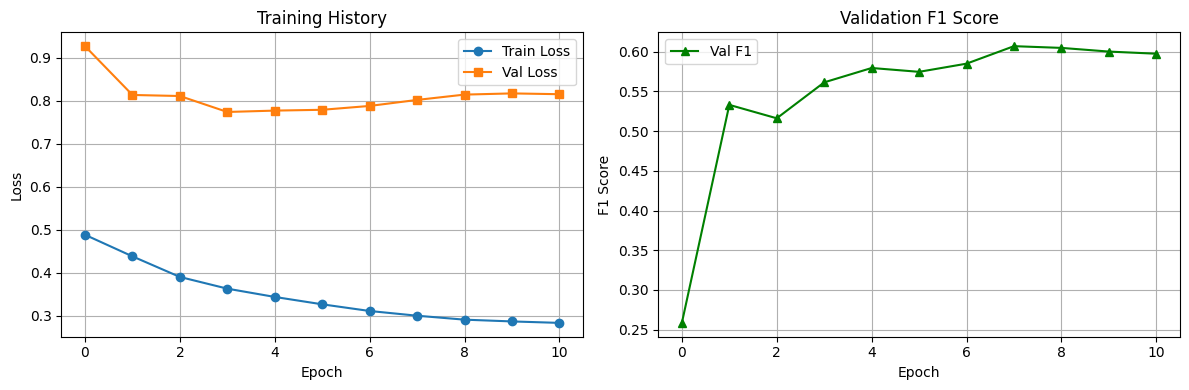

('/kaggle/working/banglabert_multitask/tokenizer_config.json',
 '/kaggle/working/banglabert_multitask/special_tokens_map.json',
 '/kaggle/working/banglabert_multitask/vocab.txt',
 '/kaggle/working/banglabert_multitask/added_tokens.json',
 '/kaggle/working/banglabert_multitask/tokenizer.json')

In [41]:
print(f"\n--- Training with LR={FIXED_LR}, smoothing={FIXED_SMOOTHING} for {EPOCHS} epochs ---")
final_model = BanglaBERTMultiTask(config, USE_GRAD_CHECKPOINT).to(DEVICE)
ce_loss_fn = nn.CrossEntropyLoss(weight=sent_class_weights, label_smoothing=FIXED_SMOOTHING)

train_with_loss(
    final_model,
    train_loader,
    val_loader,
    ce_loss_fn,
    lr=FIXED_LR,
    epochs=EPOCHS
)
final_model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

In [42]:
def load_custom_model(model_path, device=DEVICE):
    # Load the original config first
    config = AutoConfig.from_pretrained(MODEL_NAME)
    
    # Add your custom parameters
    config.n_sentiment = 3
    config.n_truth = 2
    config.dropout = 0.1
    
    # Create model
    model = BanglaBERTMultiTask(config)
    
    # Find and load the model file (always load to CPU first)
    model_files = [f for f in os.listdir(model_path) if f.endswith(('.bin', '.safetensors'))]
    if not model_files:
        raise FileNotFoundError(f"No model file found in {model_path}")
    
    model_file = os.path.join(model_path, model_files[0])
    
    if model_file.endswith(".safetensors"):
        from safetensors.torch import load_file
        state_dict = load_file(model_file, device="cpu")
    else:
        state_dict = torch.load(model_file, map_location="cpu")
    
    # Load weights (use strict=False to be more forgiving)
    model.load_state_dict(state_dict, strict=False)
    
    # Move to target device
    model.to(device)
    model.eval()
    
    return model

In [43]:
model = load_custom_model(SAVE_DIR)

In [44]:
eval_loss_fn = nn.CrossEntropyLoss(weight=sent_class_weights)
test_metrics = evaluate_with_loss(model, test_loader, eval_loss_fn)
print("\n=== Test Metrics ===")
print(f"Sentiment  : acc={test_metrics['sentiment_acc']:.3f}, macroF1={test_metrics['sentiment_f1']:.3f}")
print(f"Truthfulness: acc={test_metrics['truth_acc']:.3f}, macroF1={test_metrics['truth_f1']:.3f}")

print("\n=== Test Classification Reports ===")
print("\nSentiment Report:")
print(test_metrics["sentiment_report"])
print("\nTruthfulness Report:")
print(test_metrics["truth_report"])


=== Test Metrics ===
Sentiment  : acc=0.618, macroF1=0.580
Truthfulness: acc=0.882, macroF1=0.853

=== Test Classification Reports ===

Sentiment Report:
              precision    recall  f1-score   support

    negative       0.69      0.63      0.66      1546
     neutral       0.34      0.52      0.41       513
    positive       0.70      0.64      0.67      1494

    accuracy                           0.62      3553
   macro avg       0.58      0.60      0.58      3553
weighted avg       0.64      0.62      0.63      3553


Truthfulness Report:
              precision    recall  f1-score   support

        fake       0.76      0.81      0.79       962
        real       0.93      0.91      0.92      2591

    accuracy                           0.88      3553
   macro avg       0.85      0.86      0.85      3553
weighted avg       0.88      0.88      0.88      3553



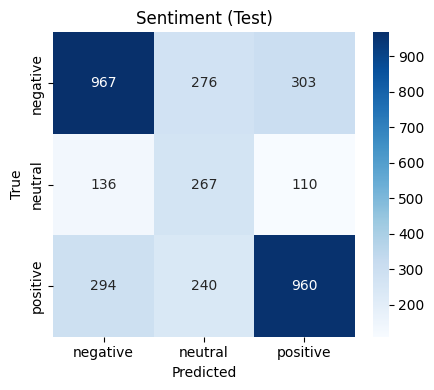

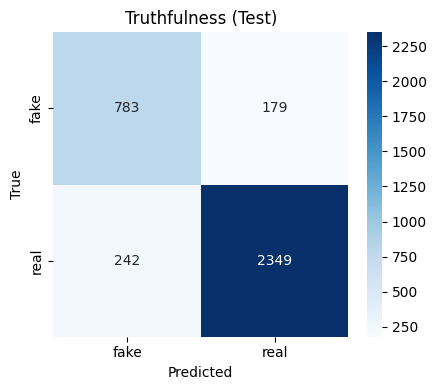

In [45]:
# Confusion matrices
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_cm(test_metrics["y_true_s"], test_metrics["y_pred_s"], [idx2sent[i] for i in range(3)], "Sentiment (Test)")
plot_cm(test_metrics["y_true_t"], test_metrics["y_pred_t"], [idx2truth[i] for i in range(2)], "Truthfulness (Test)")

In [46]:
# Error analysis
df_err = df_test.copy().reset_index(drop=True)
df_err["sent_true"] = [idx2sent[i] for i in test_metrics["y_true_s"]]
df_err["sent_pred"] = [idx2sent[i] for i in test_metrics["y_pred_s"]]
df_err["truth_true"] = [idx2truth[i] for i in test_metrics["y_true_t"]]
df_err["truth_pred"] = [idx2truth[i] for i in test_metrics["y_pred_t"]]
df_err["sent_correct"] = (df_err["sent_true"] == df_err["sent_pred"]).astype(int)
df_err["truth_correct"] = (df_err["truth_true"] == df_err["truth_pred"]).astype(int)
df_err["both_correct"] = (df_err["sent_correct"].eq(1) & df_err["truth_correct"].eq(1)).astype(int)

err_path = os.path.join(SAVE_DIR, "error_analysis_test.xlsx")
with pd.ExcelWriter(err_path, engine="openpyxl") as writer:
    df_err.to_excel(writer, index=False, sheet_name="errors")
print("Saved error analysis to:", err_path)

Saved error analysis to: /kaggle/working/banglabert_multitask/error_analysis_test.xlsx


In [47]:
# Final config
inference_config = {
    "max_length": MAX_LENGTH,
    "sentiment_map": SENTIMENT_MAP,
    "truth_map": TRUTH_MAP,
    "model_type": "banglabert-multitask",
    "alpha_sentiment": ALPHA_SENTIMENT
}
with open(os.path.join(SAVE_DIR, "inference_config.json"), "w", encoding="utf-8") as f:
    json.dump(inference_config, f, ensure_ascii=False, indent=2)

print("✅ All artifacts saved to:", SAVE_DIR)

✅ All artifacts saved to: /kaggle/working/banglabert_multitask
